# AML Group Assignment 3

***

This assignment focuses on the Neural Networks application in image classification using the Fashion_MNIST dataset, which includes a set of 28x28 grayscale images, each associated with one of 10 labels. We start by creating a bencmark model, kernelised SVM, then proceed to create and tune the hyperparameters of a Neural Network. Finally, we run and explore a version of the convolutional neural network.

***

<br/>


<div style="border-top: 3px solid gray;"></div>

### <span style= "color: navy"> Import Libraries

In [2]:
#Loading required packages
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from numpy import matrix
import numpy as np

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from sklearn.model_selection import GridSearchCV

from keras.models import load_model
import pickle

***

### <span style= "color: navy"> Data and Pre-processing

<br>

### Read Data


Train: X=(45000, 28, 28), y=(45000,)

Validation: X=(15000, 28, 28), y=(15000,)

Test: X=(10000, 28, 28), y=(10000,)


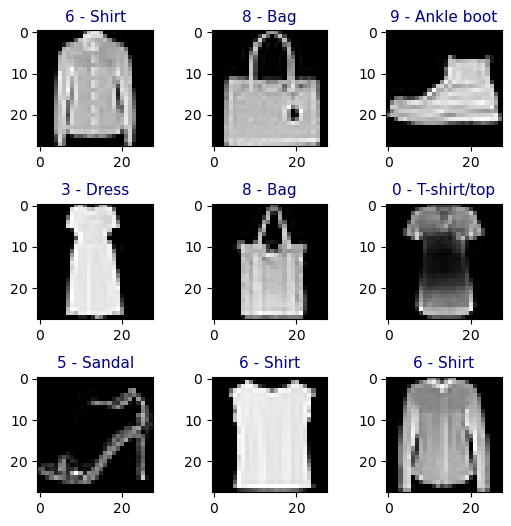

In [3]:
#Loading the data
(X_train_orig, y_train_orig), (X_test, y_test) = fashion_mnist.load_data()
#Splitting the train set into validation samples (25%)
X_train, X_val, y_train, y_val = train_test_split(X_train_orig, y_train_orig, test_size=0.25, random_state=42)

#Define labels
labels = {
    0:'T-shirt/top',
    1:'Trouser',
    2:'Pullover',
    3:'Dress',
    4:'Coat',
    5:'Sandal',
    6:'Shirt',
    7:'Sneaker',
    8:'Bag',
    9:'Ankle boot'}


# Summarize loaded dataset
print('\nTrain: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('\nValidation: X=%s, y=%s' % (X_val.shape, y_val.shape))
print('\nTest: X=%s, y=%s' % (X_test.shape, y_test.shape))

# Plot first few images
fig, axes = plt.subplots(3, 3, figsize=(6, 6))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i, ax in enumerate(axes.flat):
    # Plot raw pixel data
    ax.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    # Add title
    ax.set_title(str(y_train[i]) + ' - ' + labels[y_train[i]], size=11, color="navy")

# Show the figure
plt.show()

<br>

### Normalize the pixel to range 0-1

In [5]:
X_train = X_train.astype('float32')/255.0 #45K observations
X_val = X_val .astype('float32')/255.0 #15K observations
X_train_orig = X_train_orig.astype('float32')/255.0 #60K observations; before train-val split
X_test = X_test.astype('float32')/255.0

<br>

### Flatten Pixels for SVM
The data is two-dimensional (28x28 pixels). Therefore, it needs to be flattened as SVM can only handle one-dimensional input data. The default order 'C' will be used, which means that the function moves row by row, where it transposes the row into a column vector, then moves to the next row to do the same. 

In [6]:
# X_train_flattened = matrix.flatten(X_train, order = 'C')
# X_val_flattened = matrix.flatten(X_val, order = 'C')
# X_test_flattened = matrix.flatten(X_test, order = 'C')

X_train_flattened = np.array([image.flatten(order='C') for image in X_train])
X_val_flattened = np.array([image.flatten(order='C') for image in X_val])
X_test_flattened = np.array([image.flatten(order='C') for image in X_test])



In [7]:
print("Train Data Check: ",X_train_flattened.shape[1] == X_train.shape[1]*X_train.shape[2])

print("Validation Data Check: ",X_val_flattened.shape[1] == X_val.shape[1]*X_val.shape[2])

print("Test Data Check: ",X_test_flattened.shape[1] == X_test.shape[1]*X_test.shape[2])

Train Data Check:  True
Validation Data Check:  True
Test Data Check:  True



<div style="border-top: 3px solid gray;"></div>

## <span style = "color:#0037A4"> (a) Implement Kernelised SVM
<br>

Support vector machines use hyperplanes to divide the space of our dataset into subspaces, and classifiying predictions according to the subspace of the new data. It selects which hyperplane to choose by maximizing the margin between the points and the hyperplane. It turns out that only the closest points (or vectors if the dimension is larger than three) need to be used, these are called the support vectors. The model then follows the structure: 

**Maximize**
$$f(x) = \sum^m_{i=1}\alpha_iK(X^{(i)},X) + b$$
**Subject to**
$$\sum^p_{j=1}w^2_j = 1$$
**and**
$$Y^{(i)}f(X^{(i)}) \ge M(1 - \epsilon_i), for\ i=1, ..., m$$
**and**
$$\epsilon_i \ge 0, \sum^m_{i=1}\epsilon_i = C$$

Where the C parameter controls for the tolarance for vectors either in the wrong side of the margin or the hyperplane. Without it, our model would not generalize well due to overfitting. 
    
SVMs are known for their ability to handle high-dimensional data and their effectiveness in situations where the decision boundary is not a simple straight line. In image classification, SVMs can be a good choice, especially when the number of features is relatively high. Thus, SVMs can be applied to distinguish between different classes of images. 

The first step is to convert each image into a set of features. In image classification, these features could be pixel values, color histograms, for this particular data set we needed to normalized pixel values. The next step was to flattened the data as SVM can only handle one-dimensional input data, and our data was two dimensional with 28x28 pixels.
    

We will first use the default parameters of the SVM algorithm to fit the data with the train set. The kernel used will be Radial Basis Function, it measures similarity between two data points in infinite dimensions and then approaches classification by majority vote. While the C parameter used will be 1.0, with a squared l2 penalty.

We obtain a 87.95% accuracy rate on the test set which is high, however we will now tune hypeparameter to see if we could increase the accuracy rate by finding the optimal hyperparameters.

We will now tune the hype-parameters using the Grid Search package, we will tune the kernel and the C parameter and look for the best combination of them. For the C parameter, we will seach the optimum C in the  logspace(-2,1,21). For the kernel we will try four different kernels. We will now procede to explain the difference between each one.

1. Radial Basis Function (rbf)
    
    It measures similarity between two data points in infinite dimensions and then approaches classification by majority vote. The Radial Function is defined as:

    $$K(x_i, x_i') = exp(-\gamma \sum^p_{j=1}(x_{ij} - x_{i'j})^2)$$


2. Linear
    
    Linear kernel is the dot product of the input samples. It applied to any combination of two data points (samples) in the dataset. The dot product of the two points determines the cosine_similarity between both points. The higher the value, the more similar the points are.
    
    $$K(x_1,x_2)=x_1^Tx_2$$
    
    
3. Polynomial (poly)

    The polynomial kernel changes the notion of similarity. The kernel function is defined as:
    
    $$K(x_1,x_2)=(\gamma \ *x_1^Tx_2 + r)^d$$



4. Sigmoid

    In the sigmoid kernel, the similarity between two data points is computed using the hyperbolic tangent function. The kernel function scales and possibly shifts the dot product of the two points. The sigmoid kernel function is defined as:
    
    $$K(x_1,x_2)=tanh(\gamma \ *x_1^Tx_2 + r)$$


After the Grid search, we obtain the best parameters, were C= 7.079 and the kernel = 'rbf'. With these parameters we obtain a accuracy score of 0.88 on the validation set.

Now that we have tuned hyperparameters on the validation set, it is now time to used those hyperparameters on the test set to evaluate if our model is generalising well in unseen data.

The initial accuracy score that we obtained when we used the default settings is slightly lower than the accuracy score that we obtained after the parameters where hypertuned. This behaviour is expected and it demonstrates the importance of tuning hyperparameters, it enables us to improve the performance of the algorithm. This step is esential when implementing all sorts of algorithms. However, it is important to point out that it took a long time to find those optimal parameters, the code ran for almost two hours, which means that it is computationally costly. Lets explore if a Neural Network takes less to run and achieves a higher accuracy score than kernelised SVM. 

<div style="border-top: 3px solid gray;"></div>

## <span style = "color:#0037A4"> (b) Implement a Fully-Connected Neural Network
<br>
    
    
Neural Networks are a class of machine learning inspired by the human brain function, where a neural network consists of layers of artificial neurons/nodes connected to each other. These layers consist of an input layer (input features) which are the image pixels in this case, one or multiple hidden layers, and an output layer consisting of K nodes where K is number of labels of a categorical variable. In this case, K = 10 which is the number of fashion item labels available in the data. The output layer nodes each hold the probability of the sample belonging to the label k (probabilities $Y_1, \dots, Y_K$).
    
The input features are passed through the network layers where a set of linear functions (weights and biases) are estimated and passed through activation functions that transform the them to capture non-linear complex relationships to finally estimate the probability of each observation being classified to each of the output categories.       
    
To fit a fully connected neural network, we start by defining the network layers. First, defining the input layer by flatenning the 28x28 pixel image input. This is followed by defining two hidden layers, one with 12 neurons and the other with 8 neurons similar to the activity in session 6.5. Both layers are defined to use the relu activation function: $r(v) = max(0,v)$. The final layer defined is the output layer consisting of 10 neurons representing the 10 fashion labels. 
    
The neural network works to minimise the error between the predicted output and the actual output label through a backpropagation optimisation process. Therefore, the second step to define the model is to define the optimizer to be used and the error measure to minimise. In this case, the error measure is cross-entropy due to the classification nature of the problem, specifically the sparse categorical cross-entropy is used to since the output labels were not transformed to one-hot-encoding which would have allowed the use of categorical cross-entopy. 
    
Finally, the model is fit using the hyper-parameters epochs = 150 and batch size = 10 as was defined in the activity in session 6.5. Epochs is basically the number of iterations the fitting process will go through. It is considered to be one of the hyper-parameters of Neural Networks where a to few Epochs may lead to underfitting while a too high value could lead to overfitting to the training data. Batch size, another hyper-parameter, indicates the number of sample points that will be used during each iteration to update the estimates of the weights (coefficients). The batch size would be the sample size used to calculate the gradient of the loss function to update the model's paramaters.     

In [6]:
# reshape dataset to have a single channel
# X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
# X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
# X_val = X_val.reshape((X_val.shape[0], 28, 28, 1))
# X_train_orig = X_train_orig.reshape((X_train_orig.shape[0], 28, 28, 1))


# one hot encode target values
 # trainY = to_categorical(trainY)
 # testY = to_categorical(testY)

In [7]:
model = Sequential()
model.add(Flatten(input_shape=(28, 28))) 
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(10, activation='softmax')) #output - 10 labels

In [8]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy']) #uses sparse_categorical_crossentropy since the output labels were not transformed to one-hot-encoding

<br>

**Comment on Accuracy of Train vs Test + Train Accuracy convergence versus Epoch**

<div style="border-top: 3px solid gray;"></div>

## <span style = "color:#0037A4"> (c) Neural Network Hyper-parameter Tuning  
<br>
    

### Add one more layer between the 12-neuron layer and the input layer; decide the numbers of neurons on that layer on your own.

There are several ways to get an intuition on the number of hidden layers required in a given problem and the number of neurons for each layer. For this problem, we will focus on adding one new hidden layer with different values of neurons. We will test this approach using the train validation split. After we decide on the best hyperparameter, we will compare its performance on the test data against the original model trained in b. 

In [9]:
# Number of epochs to test
epochs = 150

# Validation split proportion
val_split = 0.25

#Retraining original model with the validation split
model_orig_callback = model.fit(X_train_orig, y_train_orig, epochs=epochs, validation_split = val_split, 
                                batch_size=10, verbose = False)

#Declaring model 2
model_32 = Sequential()
model_32.add(Flatten(input_shape=(28, 28))) 
# Adding a hidden layer with 36 neurons
model_32.add(Dense(32, activation='relu'))
model_32.add(Dense(12, activation='relu'))
model_32.add(Dense(8, activation='relu'))
model_32.add(Dense(10, activation='softmax')) #output - 10 labels

#Compiling model
model_32.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Fit the new model
model32_callback = model_32.fit(X_train_orig, y_train_orig, validation_split = val_split, 
                                epochs=epochs, batch_size=10, verbose = False)

model_64 = Sequential()
model_64.add(Flatten(input_shape=(28, 28))) 
# Adding a hidden layer with 36 neurons
model_64.add(Dense(64, activation='relu'))
model_64.add(Dense(12, activation='relu'))
model_64.add(Dense(8, activation='relu'))
model_64.add(Dense(10, activation='softmax')) #output - 10 labels

#Compiling model
model_64.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Fit the new model
model64_callback = model_64.fit(X_train_orig, y_train_orig, validation_split = val_split, 
                                epochs=epochs, batch_size=10, verbose = False)

model_128 = Sequential()
model_128.add(Flatten(input_shape=(28, 28))) 
# Adding a hidden layer with 36 neurons
model_128.add(Dense(64, activation='relu'))
model_128.add(Dense(12, activation='relu'))
model_128.add(Dense(8, activation='relu'))
model_128.add(Dense(10, activation='softmax')) #output - 10 labels

#Compiling model
model_128.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Fit the new model
model128_callback = model_128.fit(X_train_orig, y_train_orig, validation_split = val_split, 
                                  epochs=epochs, batch_size=10, verbose = False)

# Save the model
model.save('models/model.keras')
model_32.save('models/model_32.keras')
model_64.save('models/model_64.keras')
model_128.save('models/model_128.keras')

# Save the history object using pickle or another serialization method
with open('models/model_orig_callback.pkl', 'wb') as file:
    pickle.dump(model_orig_callback.history, file)

# Save the history object using pickle or another serialization method
with open('models/model32_callback.pkl', 'wb') as file:
    pickle.dump(model32_callback.history, file)
    
# Save the history object using pickle or another serialization method
with open('models/model64_callback.pkl', 'wb') as file:
    pickle.dump(model64_callback.history, file)

# Save the history object using pickle or another serialization method
with open('models/model128_callback.pkl', 'wb') as file:
    pickle.dump(model128_callback.history, file)

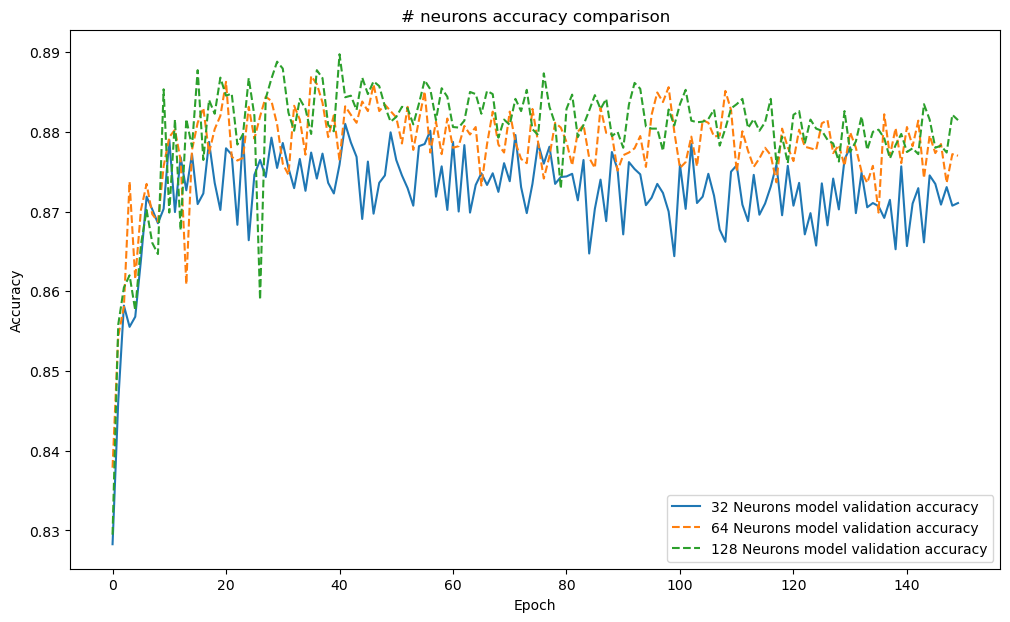

In [10]:
with open('models/model32_callback.pkl', 'rb') as file:
    model32_callback = pickle.load(file)

with open('models/model64_callback.pkl', 'rb') as file:
    model64_callback = pickle.load(file)

with open('models/model128_callback.pkl', 'rb') as file:
    model128_callback = pickle.load(file)

#Plot convergence of the 3 hyperparams
fig = plt.figure(figsize=(12,7))

plt.plot(model32_callback['val_accuracy'], label='32 Neurons model validation accuracy')
plt.plot(model64_callback['val_accuracy'], linestyle='--', label='64 Neurons model validation accuracy')
plt.plot(model128_callback['val_accuracy'], linestyle='--', label='128 Neurons model validation accuracy')
plt.title('# neurons accuracy comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

There is an indestinguisheable performanace between the model with 128 and 32 neurons in convergence. However, we see that the model with 32 neurons has the advantage of converving faster. Therefore, we will use it.

In [12]:
model_32 = load_model('models/model_32.keras')
model_128 = load_model('models/model_128.keras')

_, accuracy32 = model_32.evaluate(X_test, y_test)
_, accuracy128 = model_128.evaluate(X_test, y_test)
print('Accuracy of the new model: %.2f' % (accuracy32*100))
print('Accuracy of the previous model: %.2f' % (accuracy128*100))

313/313 [==============================] - 0s 881us/step - loss: 0.9177 - accuracy: 0.8737
Accuracy of the new model: 85.99
Accuracy of the previous model: 87.37


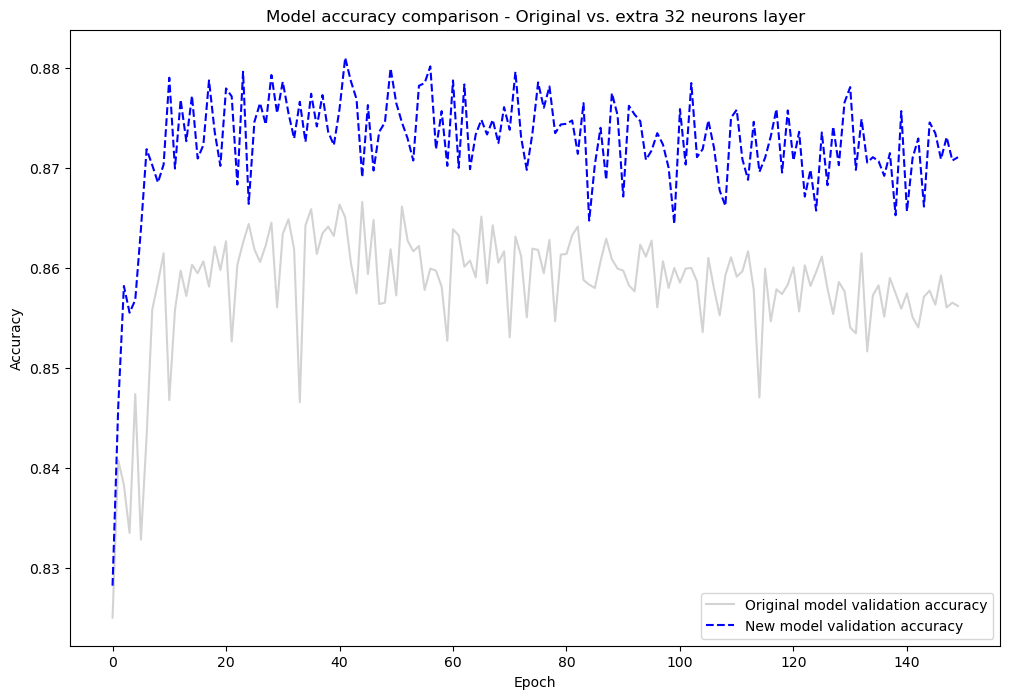

In [13]:
with open('models/model_orig_callback.pkl', 'rb') as file:
    model_orig_callback = pickle.load(file)

#Plotting the accuracy comparison on the validation split
fig = plt.figure(figsize=(12,8))

plt.plot(model_orig_callback['val_accuracy'], label='Original model validation accuracy', color='lightgrey')
plt.plot(model32_callback['val_accuracy'], linestyle='--', label='New model validation accuracy', color='blue')
plt.title('Model accuracy comparison - Original vs. extra 32 neurons layer')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [14]:
_, accuracy32 = model_32.evaluate(X_test, y_test)
_, accuracy = model.evaluate(X_test, y_test)

print('Accuracy of the new model with and extra 32 neurons layer: %.2f' % (accuracy32*100))
print('Accuracy of the previous model: %.2f' % (accuracy*100))

313/313 [==============================] - 0s 774us/step - loss: 0.6009 - accuracy: 0.8436
Accuracy of the new model with and extra 32 neurons layer: 85.99
Accuracy of the previous model: 84.36


We see from the plot above an improvement in the convergence of the model with an extra layer. Applying the newly tranined model to the test data, we can compare it to the pervious model tranined in b. We see that there was some improvement from the extra layer.

### Change the numbers of the neurons (12 and 8) to other values.

In [15]:
epochs = 150

#Declaring model 2
model_24_16 = Sequential()
model_24_16.add(Flatten(input_shape=(28, 28))) 
# Adding a hidden layer with 36 neurons
model_24_16.add(Dense(24, activation='relu'))
model_24_16.add(Dense(16, activation='relu'))
model_24_16.add(Dense(10, activation='softmax')) #output - 10 labels

#Compiling model
model_24_16.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Fit the new model
model_24_16_callback = model_24_16.fit(X_train_orig, y_train_orig, validation_split = val_split, 
                              epochs=epochs, batch_size=10, verbose = False)

model_64_32 = Sequential()
model_64_32.add(Flatten(input_shape=(28, 28))) 
# Adding a hidden layer with 36 neurons
model_64_32.add(Dense(64, activation='relu'))
model_64_32.add(Dense(32, activation='relu'))
model_64_32.add(Dense(10, activation='softmax')) #output - 10 labels

#Compiling model
model_64_32.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Fit the new model
model_64_32_callback = model_64_32.fit(X_train_orig, y_train_orig, validation_split = val_split, 
                              epochs=epochs, batch_size=10, verbose = False)

model_32_128 = Sequential()
model_32_128.add(Flatten(input_shape=(28, 28))) 
# Adding a hidden layer with 36 neurons
model_32_128.add(Dense(32, activation='relu'))
model_32_128.add(Dense(128, activation='relu'))
model_32_128.add(Dense(10, activation='softmax')) #output - 10 labels

#Compiling model
model_32_128.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Fit the new model
model_32_128_callback = model_32_128.fit(X_train_orig, y_train_orig, validation_split = val_split, 
                              epochs=epochs, batch_size=10, verbose = False)

# Save the model
model_24_16.save('models/model_24_16.keras')
model_64_32.save('models/model_64_32.keras')
model_32_128.save('models/model_32_128.keras')

# Save the history object using pickle or another serialization method
with open('models/model_24_16_callback.pkl', 'wb') as file:
    pickle.dump(model_24_16_callback.history, file)

# Save the history object using pickle or another serialization method
with open('models/model_64_32_callback.pkl', 'wb') as file:
    pickle.dump(model_64_32_callback.history, file)
    
# Save the history object using pickle or another serialization method
with open('models/model_32_128_callback.pkl', 'wb') as file:
    pickle.dump(model_32_128_callback.history, file)


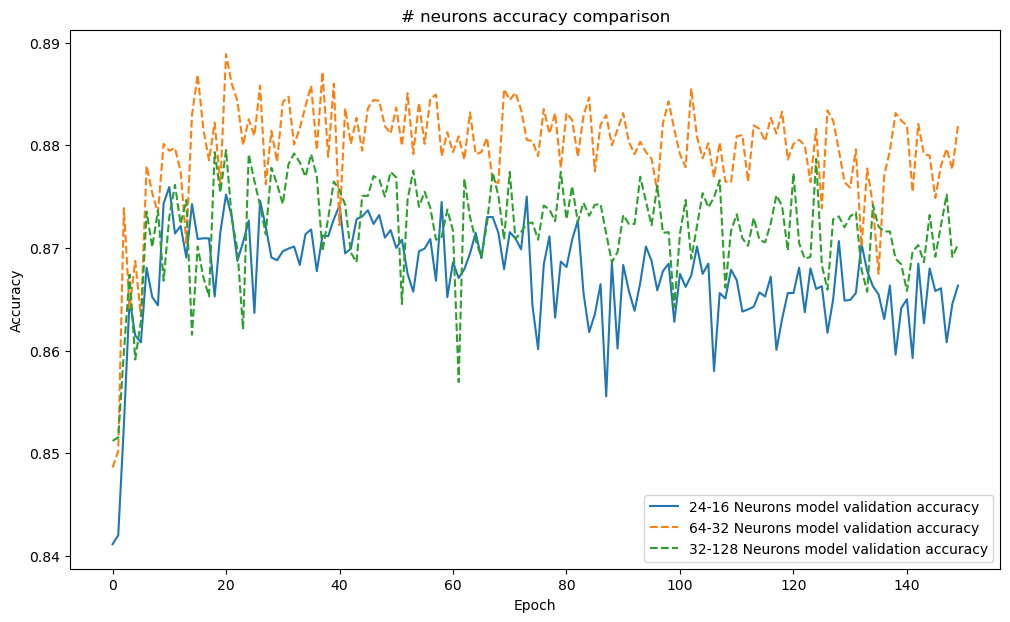

In [16]:
# Loading models from saved data
with open('models/model_24_16_callback.pkl', 'rb') as file:
    model_24_16_callback = pickle.load(file)

with open('models/model_64_32_callback.pkl', 'rb') as file:
    model_64_32_callback = pickle.load(file)

with open('models/model_32_128_callback.pkl', 'rb') as file:
    model_32_128_callback = pickle.load(file)

#Plot convergence of the 3 hyperparams
fig = plt.figure(figsize=(12,7))

# Plotting the validation per epoch plots
plt.plot(model_24_16_callback['val_accuracy'], label='24-16 Neurons model validation accuracy')
plt.plot(model_64_32_callback['val_accuracy'], linestyle='--', label='64-32 Neurons model validation accuracy')
plt.plot(model_32_128_callback['val_accuracy'], linestyle='--', label='32-128 Neurons model validation accuracy')
plt.title('# neurons accuracy comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

### Change the loss function (through the loss in the compile function).

We will now use our data with the y vector being One-hot encoded. That way, we can apply binary crossentropy as the loss function.
This time, we did not get significant improvements in the model's accuracy. We could argue that we have a faster convergence in this case, but that is hard to verify with these graphs.

In [17]:
#Training a model with binary cross entropy

epochs = 150

from keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train, 10)
y_val_one_hot = to_categorical(y_val, 10)
y_test_one_hot = to_categorical(y_test, 10)

#Declaring model 4 as a replica of the original model

model_bin = Sequential()
model_bin.add(Flatten(input_shape=(28, 28))) 
# Changing number of neurons of the hidden layers
model_bin.add(Dense(16, activation='relu'))
model_bin.add(Dense(10, activation='sigmoid')) #output - 10 labels

model_bin.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['accuracy'])

model_bin_callback = model_bin.fit(X_train, y_train_one_hot, validation_split=val_split, 
                                   epochs=epochs, batch_size=10, verbose=False)

# Save the model
model_bin.save('models/model_bin.keras')

# Save the history object using pickle or another serialization method
with open('models/model_bin_callback.pkl', 'wb') as file:
    pickle.dump(model_bin_callback.history, file)

In [15]:
#Training a model with mean squared error
epochs = 150

val_split = 0.25

from keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train, 10)
y_val_one_hot = to_categorical(y_val, 10)
y_test_one_hot = to_categorical(y_test, 10)

model_squared = Sequential()
model_squared.add(Flatten(input_shape=(28, 28))) 
# Changing number of neurons of the hidden layers
model_squared.add(Dense(16, activation='relu'))
model_squared.add(Dense(10, activation='sigmoid')) #output - 10 labels

model_squared.compile(loss='mean_squared_error', optimizer='adam', 
              metrics=['accuracy'])

model_squared_callback = model_squared.fit(X_train, y_train_one_hot, validation_split=val_split, 
                                   epochs=epochs, batch_size=10, verbose=False)

# Save the model
model_squared.save('models/model_squared.keras')

# Save the history object using pickle or another serialization method
with open('models/model_squared_callback.pkl', 'wb') as file:
    pickle.dump(model_squared_callback.history, file)

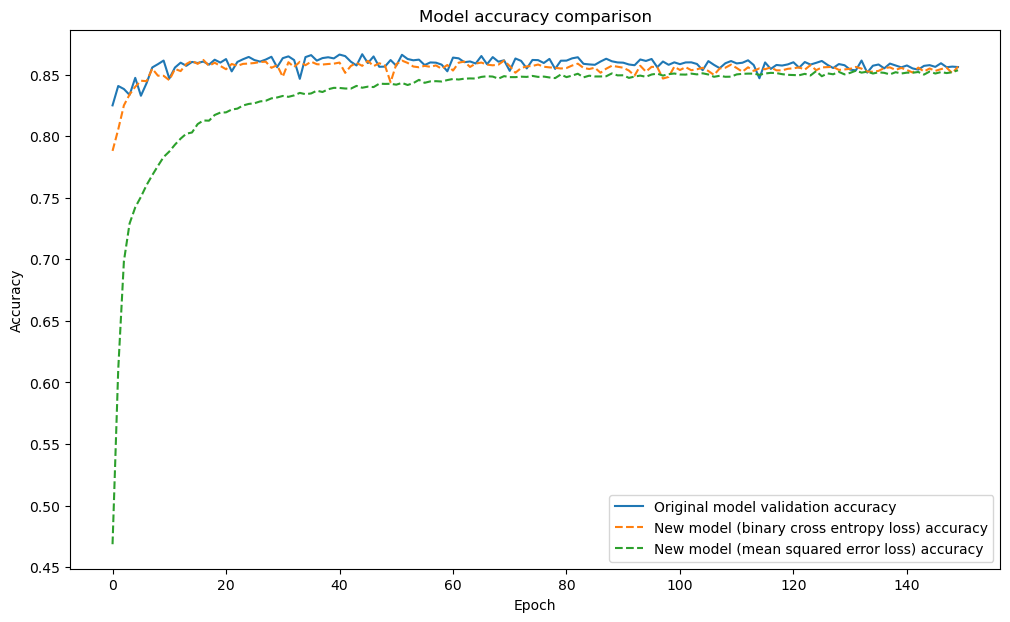

In [16]:
with open('models/model_bin_callback.pkl', 'rb') as file:
    model_bin_callback = pickle.load(file)

with open('models/model_orig_callback.pkl', 'rb') as file:
    model_orig_callback = pickle.load(file)
    
with open('models/model_squared_callback.pkl', 'rb') as file:
    model_squared_callback = pickle.load(file)

#Plot convergence of the 3 hyperparams
fig = plt.figure(figsize=(12,7))

# Plotting the new model agains the original
plt.plot(model_orig_callback['val_accuracy'], label='Original model validation accuracy')
plt.plot(model_bin_callback['val_accuracy'], linestyle='--', label='New model (binary cross entropy loss) accuracy')
plt.plot(model_squared_callback['val_accuracy'], linestyle='--', label='New model (mean squared error loss) accuracy')
plt.title('Model accuracy comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

In [21]:
# Load models
model_bin = load_model('models/model_bin.keras')
model = load_model('models/model.keras')
model_squared = load_model('models/model_squared.keras')


_, accuracy_bin = model_bin.evaluate(X_test, y_test_one_hot)
_, accuracy = model.evaluate(X_test, y_test)
_, accuracy_squared = model_squared.evaluate(X_test, y_test_one_hot)


print('Accuracy of the new model with and binary crossentropy error: %.2f' % (accuracy_bin*100))
print('Accuracy of the previous model: %.2f' % (accuracy*100))
print('Accuracy of the new model with mean squared error: %.2f' % (accuracy_squared*100))

313/313 [==============================] - 1s 3ms/step - loss: 0.0239 - accuracy: 0.8416
Accuracy of the new model with and binary crossentropy error: 10.00
Accuracy of the previous model: 10.00
Accuracy of the new model with mean squared error: 84.16


### Change the epochs and batch_size in the fit function.

In [20]:
epochs = 150

#Loading model from history
model = load_model('models/model.keras')

#Declaring different batch sizes
batch_sizes = [10, 32, 64, 128]

# Training models for different batch sizes and storing the results in a dictionary
model_b10_callback =  model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, 
                                    batch_size=batch_sizes[0], verbose=False)

model_b32_callback =  model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, 
                                    batch_size=batch_sizes[1], verbose=False)

model_b64_callback =  model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, 
                                    batch_size=batch_sizes[2], verbose=False)

model_b128_callback =  model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, 
                                    batch_size=batch_sizes[3], verbose=False)


# Save the history object using pickle or another serialization method
with open('models/model_b10_callback.pkl', 'wb') as file:
    pickle.dump(model_b10_callback.history, file)

# Save the history object using pickle or another serialization method
with open('models/model_b32_callback.pkl', 'wb') as file:
    pickle.dump(model_b32_callback.history, file)

# Save the history object using pickle or another serialization method
with open('models/model_b64_callback.pkl', 'wb') as file:
    pickle.dump(model_b64_callback.history, file)

# Save the history object using pickle or another serialization method
with open('models/model_b128_callback.pkl', 'wb') as file:
    pickle.dump(model_b128_callback.history, file)


1500/1500 [==============================] - 1s 752us/step - loss: 0.3130 - accuracy: 0.8989
Batch Size: 10, Validation Accuracy: 0.8989333510398865, Validation Loss: 0.31295013427734375
469/469 [==============================] - 1s 804us/step - loss: 0.3129 - accuracy: 0.8989
Batch Size: 32, Validation Accuracy: 0.8989333510398865, Validation Loss: 0.3129498064517975
235/235 [==============================] - 0s 898us/step - loss: 0.3129 - accuracy: 0.8989
Batch Size: 64, Validation Accuracy: 0.8989333510398865, Validation Loss: 0.31294992566108704
118/118 [==============================] - 0s 983us/step - loss: 0.3129 - accuracy: 0.8989
Batch Size: 128, Validation Accuracy: 0.8989333510398865, Validation Loss: 0.3129499554634094


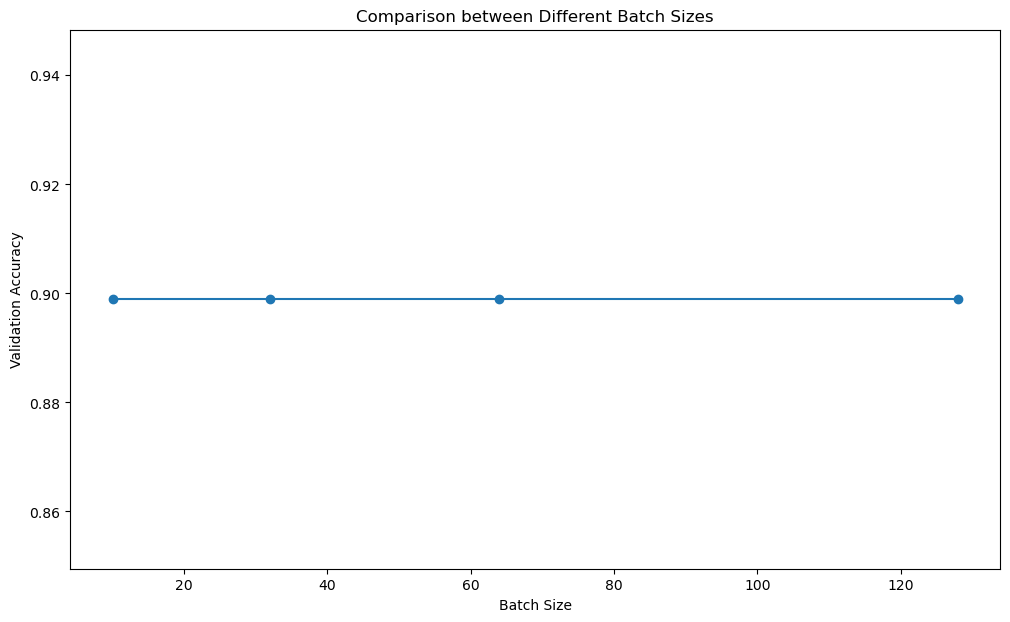

In [27]:
# Loading models from memory
model = load_model('models/model.keras')

# Initialize empty list
results = []

# Populate list with scores
for i, batch_size in enumerate(batch_sizes):
    results.append(model.evaluate(X_val, y_val, batch_size=batch_size))
    print(f"Batch Size: {batch_size}, Validation Accuracy: {results[i][1]}, Validation Loss: {results[i][0]}")

#Plot convergence of the 3 hyperparams
fig = plt.figure(figsize=(12,7))

plt.plot(batch_sizes, [result[1] for result in results], marker='o')
plt.xlabel('Batch Size')
plt.ylabel('Validation Accuracy')
plt.title('Comparison between Different Batch Sizes')
plt.show()

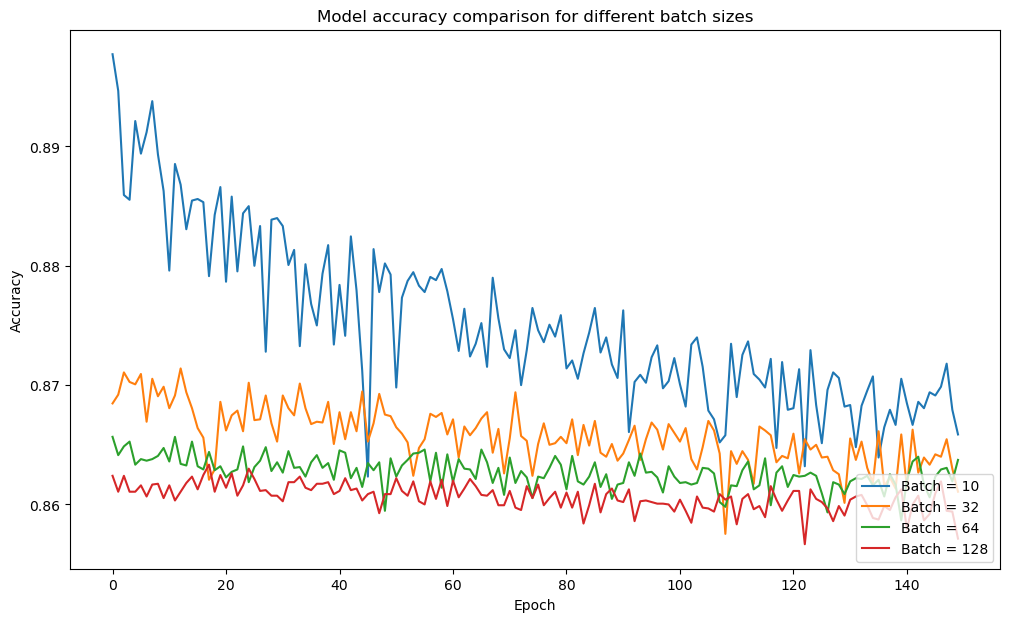

In [22]:
#Loading files from memory
with open('models/model_b10_callback.pkl', 'rb') as file:
    model_b10_callback = pickle.load(file)

with open('models/model_b32_callback.pkl', 'rb') as file:
    model_b32_callback = pickle.load(file)
    
with open('models/model_b64_callback.pkl', 'rb') as file:
    model_b64_callback = pickle.load(file)
    
with open('models/model_b128_callback.pkl', 'rb') as file:
    model_b128_callback = pickle.load(file)
    
#Plot convergence of the 3 hyperparams
fig = plt.figure(figsize=(12,7))

# Plotting the new model agains the original
plt.plot(model_b10_callback['val_accuracy'], label='Batch = 10')
plt.plot(model_b32_callback['val_accuracy'], label='Batch = 32')
plt.plot(model_b64_callback['val_accuracy'], label='Batch = 64')
plt.plot(model_b128_callback['val_accuracy'], label='Batch = 128')

plt.title('Model accuracy comparison for different batch sizes')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

***

## Best Model


can print some of the predictions similar to what is done here:
https://www.tensorflow.org/tutorials/keras/classification

<div style="border-top: 3px solid gray;"></div>

## <span style = "color:#0037A4"> (d) Convolutional Neural Network (CNN)  
<br>
    

In [ ]:
# baseline cnn model for fashion mnist
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.model_selection import KFold
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
 
# load train and test dataset
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = fashion_mnist.load_data()
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY
 
# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm
 
# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model
 
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # append scores
        scores.append(acc)
        histories.append(history)
    return scores, histories
 
# plot diagnostic learning curves
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        pyplot.subplot(211)
        pyplot.title('Cross Entropy Loss')
        pyplot.plot(histories[i].history['loss'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        pyplot.subplot(212)
        pyplot.title('Classification Accuracy')
        pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
        pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    pyplot.show()
 
# summarize model performance
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # box and whisker plots of results
    pyplot.boxplot(scores)
    pyplot.show()
 
# run the test harness for evaluating a model
def run_test_harness():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # evaluate model
    scores, histories = evaluate_model(trainX, trainY)
    # learning curves
    summarize_diagnostics(histories)
    # summarize estimated performance
    summarize_performance(scores)
 
# entry point, run the test harness
run_test_harness()

**Model Definition – ‘define_model’ Function:**

The ‘define_model’ function lays down the blueprint for the CNN model, using a Keras structure that stacks different layers one after the other. It starts with a ‘Conv2D’ layer having 32 filters to pick up patterns from the 28×28 images. A 3x3 kernel and the ReLU activation are chosen to effectively capture details and introduce the necessary complexity into the model's learning. The initial weights are set using the ‘He uniform’ approach, compatible with ReLU, to maintain consistent learning across layers. After the convolutional layer, a ‘MaxPooling2D’ layer simplifies the model's output by condensing the data, while a ‘Flatten’ layer prepares the data for the final classification by converting it into a one-dimensional array. The network ends with ‘Dense’ layers, including a softmax output layer that classifies the images into one of the ten categories. The model is put together with an SGD optimiser, fine-tuned for gradual and steady learning. This design is intentional for handling image data directly, maintaining the important structural details that are lost when data is flattened.


**Model Evaluation – ‘evaluate_model’ Function:**

The ‘evaluate_model’ function adopts k-fold cross-validation to ensure that our CNN model is evaluated thoroughly. This compensates for the absence of a separate validation dataset in Fashion-MNIST. By dividing the data into different folds and using each in turn for validation, we make sure that all data gets a chance to test the model, which helps us trust its ability to predict new images. The process is detailed, training fresh instances of the model for each fold, fine-tuning each session with specific epochs and batch sizes for efficiency and effectiveness. We then measure how well the model can apply what it has learned to new data and the accuracy results from each fold give us a solid indication of the model's overall performance.


**Learning Diagnostics – ‘summarize_diagnostics’ Function:**

The 'summarize_diagnostics' function is our tool for visualising the model's training journey. It creates plots that show how loss and accuracy evolve through the training epochs for both the training and validation datasets. This visual data is crucial  as it helps understand how well the model is learning and can indicate if there is a need to make any adjustments, like changing the learning rate or adding methods to prevent overfitting. Ideally, we want to see the loss decreasing and accuracy increasing consistently and these pots help us keep track of that progress.

**Validation Setup:**

For the validation process, the script employed a 5-fold cross-validation approach, an integral part of the ‘evaluate_model’ function. This method divides the normalised dataset into five unique subsets. In each round of validation, one subset is reserved for testing the model's performance and the remaining four are used for training. This cycle is repeated five times, ensuring that each subset serves as a validation set once. This strategy is not just a safeguard against overfitting but also reinforces the model's ability to generalise which is key to its success when facing a diverse array of new fashion items in practical scenarios.

**Output of the Model:**

The output and plots for the ‘F_MNIST.py’ script reveals a well-performing model with an average validation accuracy of 91.040% across the 5-fold cross-validation process, indicated by a low standard deviation of 0.307%. The learning curves display a satisfactory convergence of training accuracy, as shown by the blue line, which suggests the model is effectively learning with each epoch. However, a slight yet consistent gap between the training (blue) and validation (yellow) accuracy lines could hint at the beginnings of overfitting, as the model performs slightly better on the training data compared to the unseen validation data. The boxplot further confirms the model's stability, with a tight interquartile range and an outlier that does not significantly affect the overall performance.


**Comparison of the Models:**

n